# Прогнозирование оттока клиентов фитнес-центра.

**Оглавление**
* [Описание проекта](#description)
* [Получение исходных данных](#reading)
* [Исследовательский анализ данных EDA](#EDA)
* [Формирование прогнозной модели на основе логистической регрессии](#Logisticregression)
* [Формирование прогнозной модели на основе RandomForestClassifier](#Randomforestclassifier)
* [Категоризация клиентов](#clustering)
* [Рекомендации для маркетинговой стратегии по группам клиентов](#marketing)

<a name="description"></a>
**Описание проекта**\
Исходные данные представляют собой информацию о клиентах фитнес-центра. Основная проблема  - отток клиентов. 
Задачи:
* Сформировать модель прогнозирования оттока (на уровне следующего месяца);
* Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* Проанализировать основные признаки, наиболее сильно влияющие на отток;
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

In [2]:
!pip install ydata_profiling

   ---------------------------------------- 0.0/357.9 kB ? eta -:--:--
   --- ----------------------------------- 30.7/357.9 kB 660.6 kB/s eta 0:00:01
   --- ----------------------------------- 30.7/357.9 kB 660.6 kB/s eta 0:00:01
   ------ -------------------------------- 61.4/357.9 kB 465.5 kB/s eta 0:00:01
   ------------- ------------------------ 122.9/357.9 kB 722.1 kB/s eta 0:00:01
   ------------------ ------------------- 174.1/357.9 kB 748.1 kB/s eta 0:00:01
   --------------------------- ---------- 256.0/357.9 kB 923.9 kB/s eta 0:00:01
   ------------------------------ ------- 286.7/357.9 kB 883.3 kB/s eta 0:00:01
   ------------------------------------ - 348.2/357.9 kB 938.7 kB/s eta 0:00:01
   -------------------------------------- 357.9/357.9 kB 927.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/104.8 kB ? eta -:--:--
   ----------------------- ---------------- 61.4/104.8 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 104.8/104.8 kB 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
manim 0.18.0 requires decorator<6.0.0,>=5.0.7, but you have decorator 4.4.2 which is incompatible.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.7.6 which is incompatible.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.


In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from ydata_profiling import ProfileReport
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler

<a name="reading"></a>
**Получение исходных данных**

In [3]:
fit=pd.read_csv('gym_churn.csv') 

<a name="EDA"></a>
**Исследовательский анализ данных (EDA)**

In [4]:
fit.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
fit.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [6]:
ProfileReport(fit, minimal = True) # Формирование отчета для исследования данных

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Пропущенных значений и дубликатов нет. Категориальные данные представлены в числовом формате.

In [11]:
fit.mean() # расчет средних значений признаков для тех кто ушел и остался

gender                                 0.510250
Near_Location                          0.845250
Partner                                0.486750
Promo_friends                          0.308500
Phone                                  0.903500
Contract_period                        4.681250
Group_visits                           0.412250
Age                                   29.184250
Avg_additional_charges_total         146.943728
Month_to_end_contract                  4.322750
Lifetime                               3.724750
Avg_class_frequency_total              1.879020
Avg_class_frequency_current_month      1.767052
Churn                                  0.265250
dtype: float64

In [12]:
fit.groupby(by = 'Churn').mean() # расчет средних значений признаков для тех кто ушел и остался

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Средние значения демонстрируют, что реже уходят те, кто живет или работает поблизости, сотрудники компаний-партнеров, те кто пришел по рекомендации друзей, те кто взял длительные абонементы, более старшего возраста, имеющие в среднем около двух посещений в неделю.

In [13]:
left = fit.query('Churn == 1') # Разделение данных на две группы: отток и активные клиенты
stay = fit.query('Churn == 0')

In [14]:
def col(i): # функция, которая формирует графики распредлений признаков по категориям "остались/ушли"
    pivo = pd.pivot_table(data = fit, index = 'Churn', columns = fit.iloc[:,i], values ='Age', aggfunc = 'count').reset_index()
    pivo.columns=['Churn',fit.columns[i]+'_0', fit.columns[i]+'_1']
    m=plt.bar(x = pivo['Churn']-0.1, height = pivo.iloc[:,1], width = 0.2, label = pivo.columns[1])
    w=plt.bar(x = pivo['Churn']+0.1, height = pivo.iloc[:,2], width = 0.2, label = pivo.columns[2])
    plt.xticks(ticks = [0,1], labels = ['остались','отток'])
    plt.legend()
    plt.bar_label(m)
    plt.bar_label(w)
    plt.show()

In [15]:
categ=pd.Series([0,1,2,3,4,6]) # номера колонок с категориальными значениями

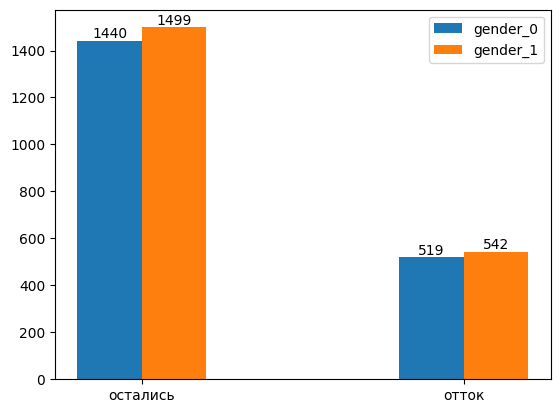

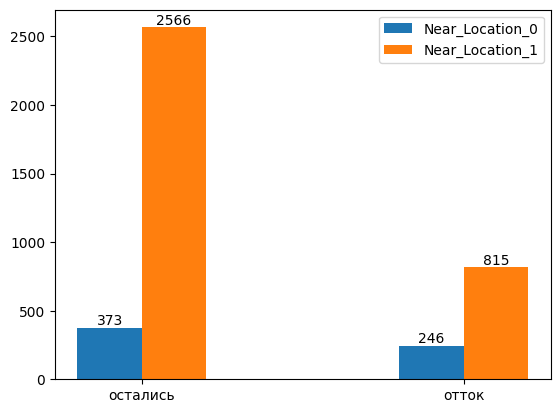

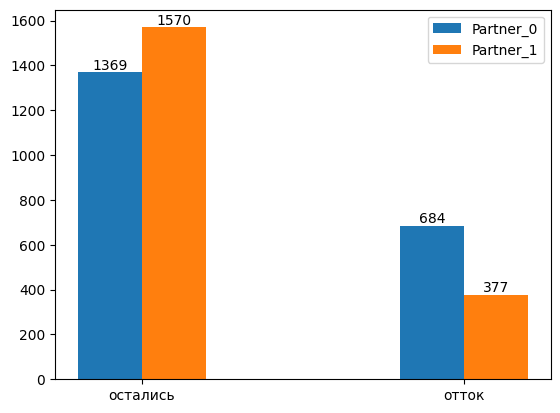

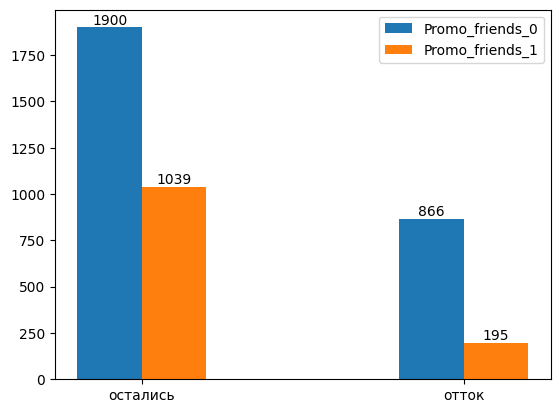

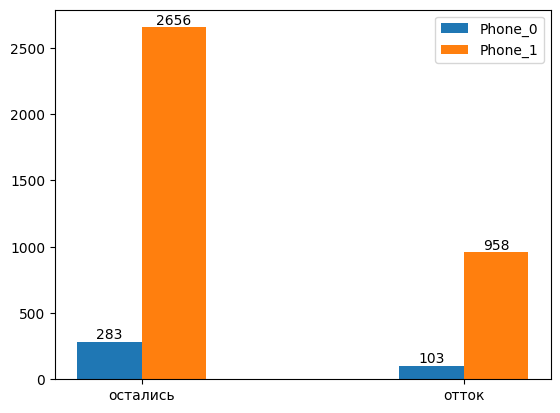

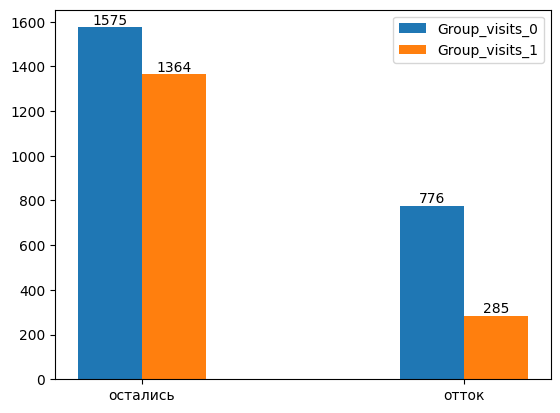

In [17]:
for i in categ:
    col(i) # построение бинарных распределений для категориальных данных в разбивке по группам "остались/ушли"

Клиенты, работающие в компаниях-партнерах более лояльны.

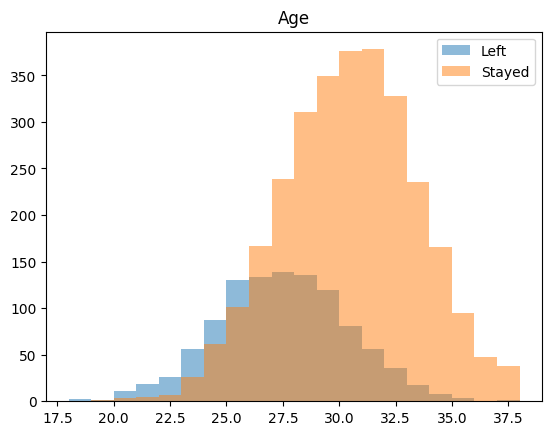

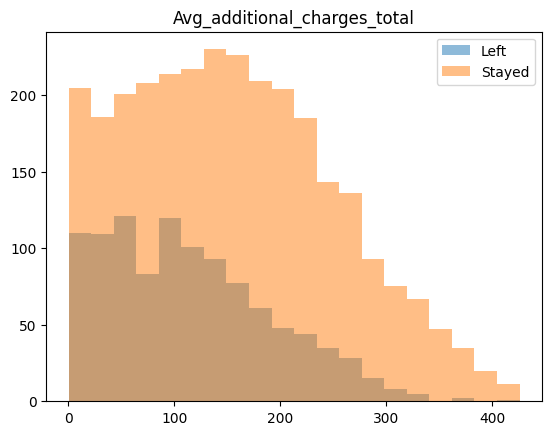

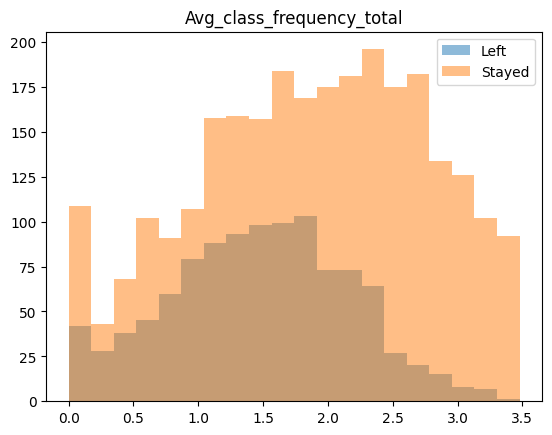

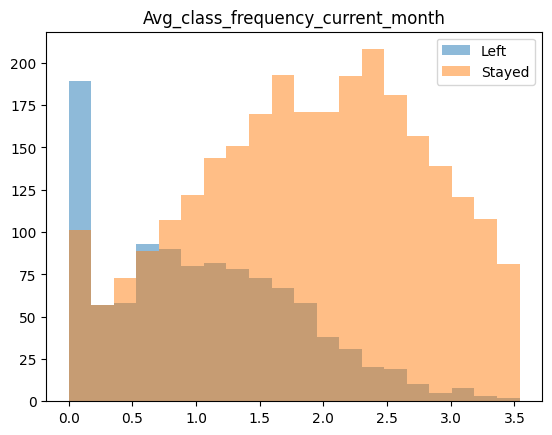

In [18]:
categ2 = pd.Series([7,8,11,12])
for i in categ2:
    n,bins, patches = plt.hist(left.iloc[:,i], bins = 20, alpha = 0.5, label = 'Left')
    plt.hist(stay.iloc[:,i], bins = bins,alpha = 0.5, label = 'Stayed')
    plt.legend()
    plt.title(left.columns[i])
    plt.show()

Нулевая посещаемость в текущий месяц с большой долей вероятности свидетельствует о последующем оттоке клиента.

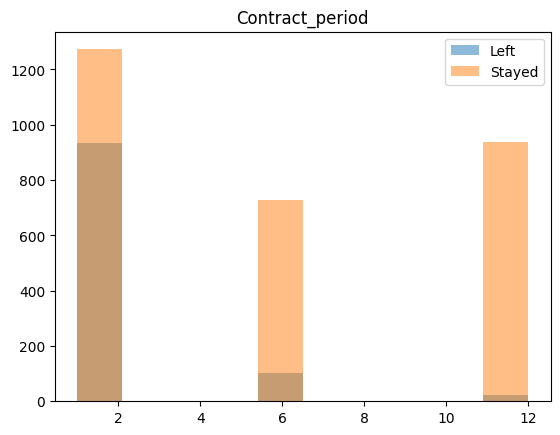

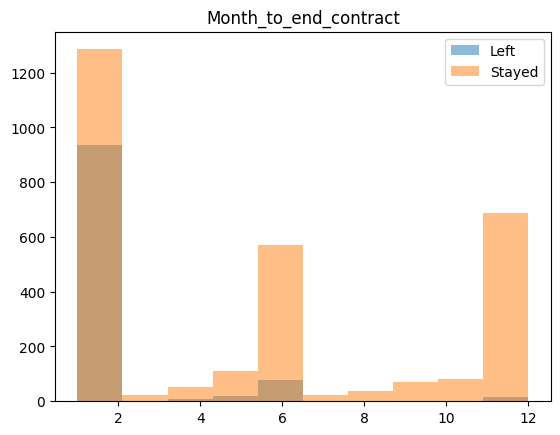

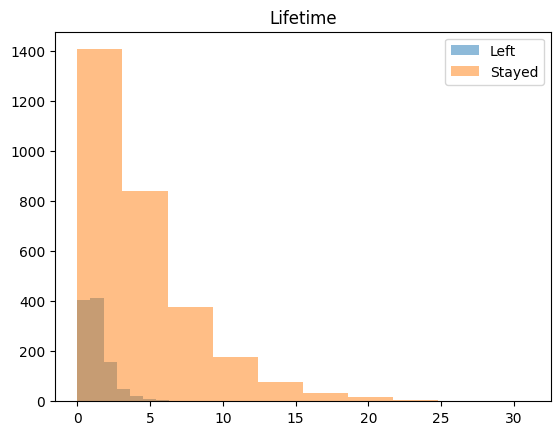

In [22]:
categ3 = pd.Series([5,9,10]) # номера колонок с дискретными признаками
for i in categ3: # построение графиков для дискретных признаков
    plt.hist(left.iloc[:,i], alpha = 0.5, label = 'Left')
    plt.hist(stay.iloc[:,i], alpha = 0.5, label = 'Stayed')
    plt.legend()
    plt.title(left.columns[i])
    plt.show()

Для группы ушедших клиентов характерен 1-месячный абонемент или окончание абонемента.

<Axes: >

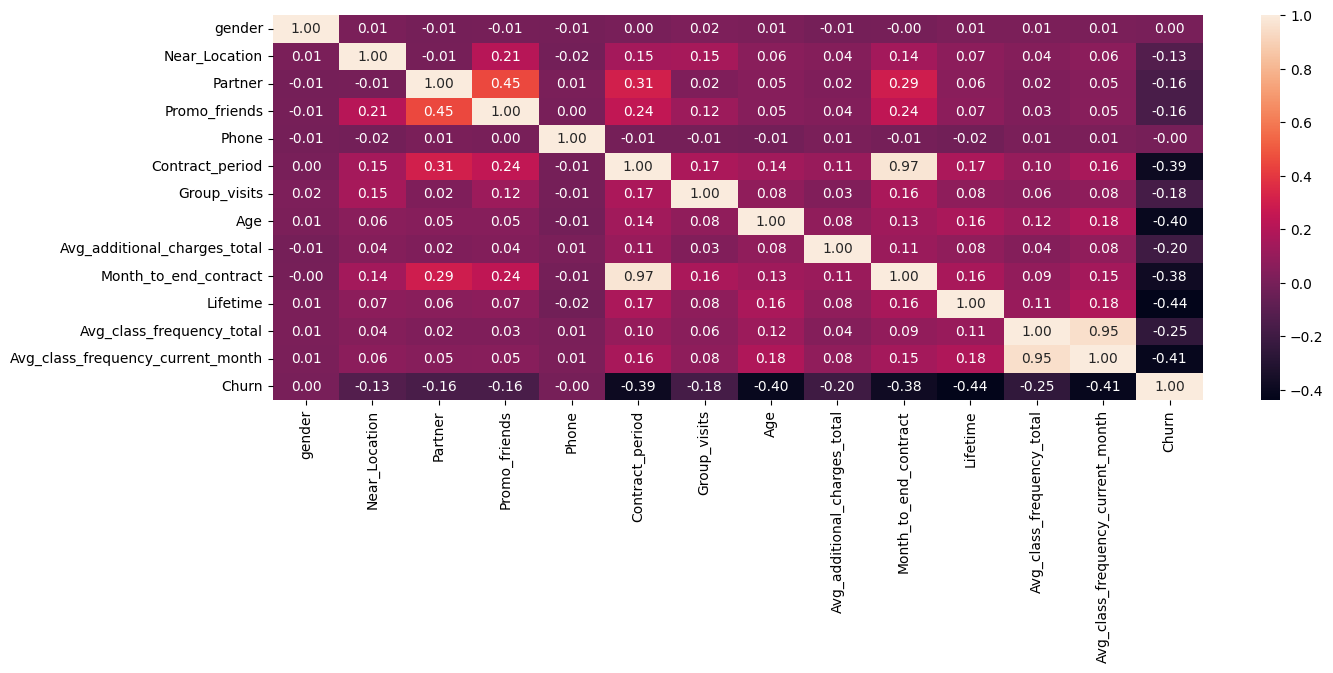

In [23]:
cor = fit.corr() # матрица корреляций
fig, ax = plt.subplots(figsize=(15,5)) 
sns.heatmap(cor, annot = True, fmt = ".2f") # тепловая карта на основе матрицы корреляций

<a name="Logisticregression"></a>
**Формирование прогнозной модели на основе логистической регрессии**

In [24]:
X = fit.drop('Churn', axis = 1)
y=fit['Churn'] # разделение данных на признаки (матрица X) и целевую переменную (y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0) # разделение модели на обучающую и валидационную выборку
model = LogisticRegression(max_iter = 1000)  
model.fit(X_train,y_train)
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, predictions)
precision = precision_score (y_test, predictions)
recall = recall_score (y_test, predictions)
print(acc, precision, recall) # вывод на экран метрик, характеризующих качество модели

0.92375 0.8586387434554974 0.8282828282828283


<a name="Randomforestclassifier"></a>
**Формирование прогнозной модели на основе RandomForestClassifier**

In [25]:
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test) 
acc_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score (y_test, y_pred)
recall_rf = recall_score (y_test, y_pred)
print(acc_rf, precision_rf, recall_rf)# вывод на экран метрик, характеризующих качество модели

0.9125 0.8440860215053764 0.7929292929292929


Метрики для логистической регрессии выше, чем для RandomForestClassifier, поэтому ее целесообразно использовать для прогнозирования.

<a name="clustering"></a>
**Категоризация клиентов**

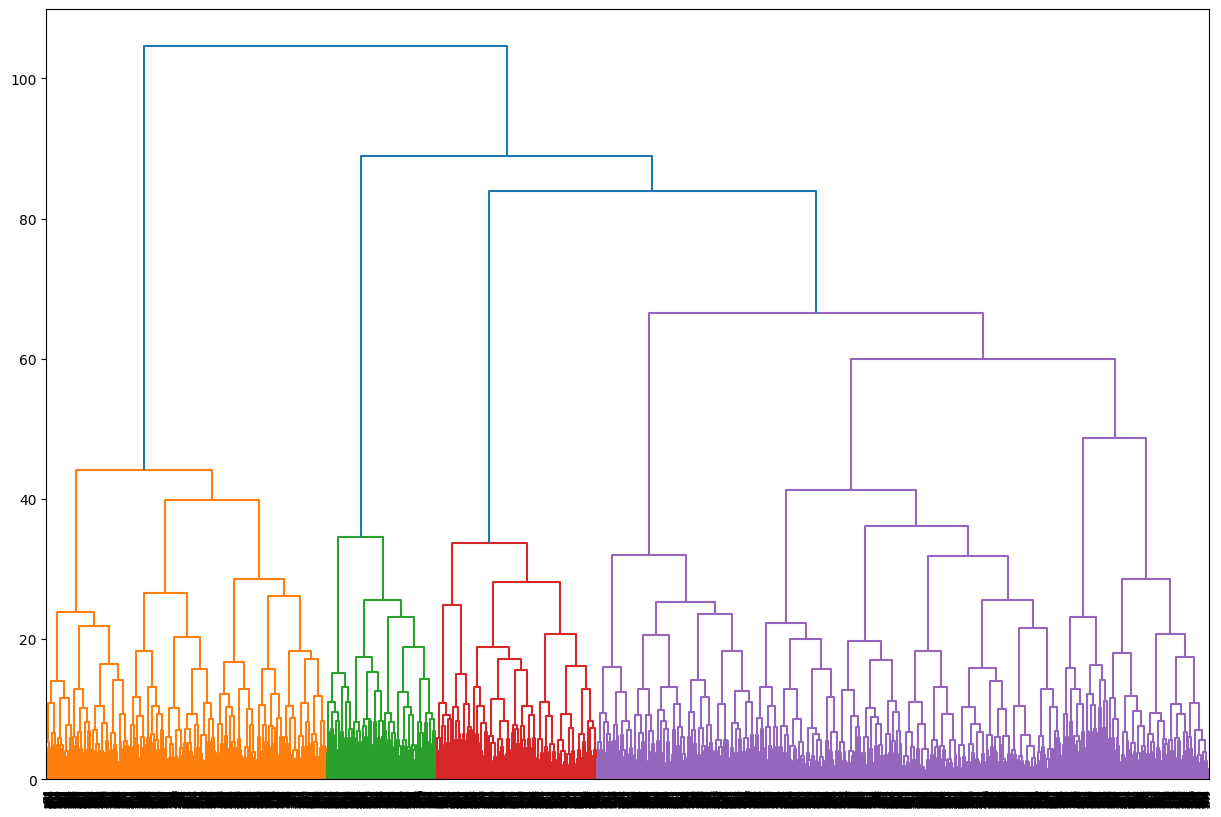

In [27]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() # вывод на экран дендрограммы

In [28]:
cl = 4 # количество кластеров выбранов соответствии с дендрограммой, а также на основе анализа нескольких вариантов
km = KMeans(n_clusters = cl)
labels = km.fit_predict(X_sc)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [29]:
fit['claster']= labels # добавление колонки с категориями

In [30]:
piv = pd.pivot_table(data = fit, index = 'claster', columns = 'Churn', values = 'Age', aggfunc = 'count' ).reset_index() # формирование сводной таблицы для анализа оттока по категориям
piv.columns = ['claster','Churn_0','Churn_1']
piv['perc'] = piv['Churn_1']/(piv['Churn_0']+piv['Churn_1'])
piv['number']=piv['Churn_1']+piv['Churn_0']
print(piv.head())

   claster  Churn_0  Churn_1      perc  number
0        0      646      828  0.561737    1474
1        1      283      103  0.266839     386
2        2     1050       32  0.029575    1082
3        3      960       98  0.092628    1058


Доля оттока существенно изменяется по кластерам

In [31]:
left = fit.query('Churn == 1')
stay = fit.query('Churn == 0')

In [32]:
categ_cat = pd.Series(np.arange(0,cl,1))
print(categ_cat)
print(categ2)

0    0
1    1
2    2
3    3
dtype: int32
0     7
1     8
2    11
3    12
dtype: int64


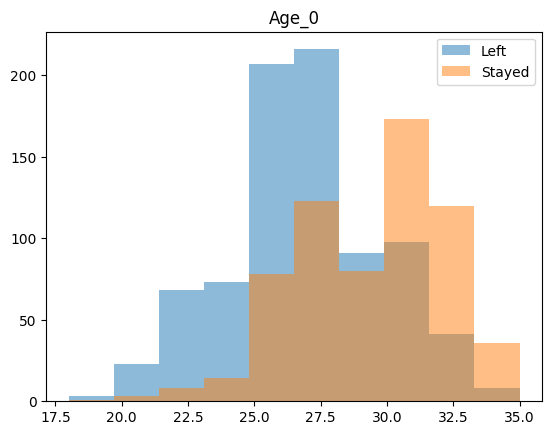

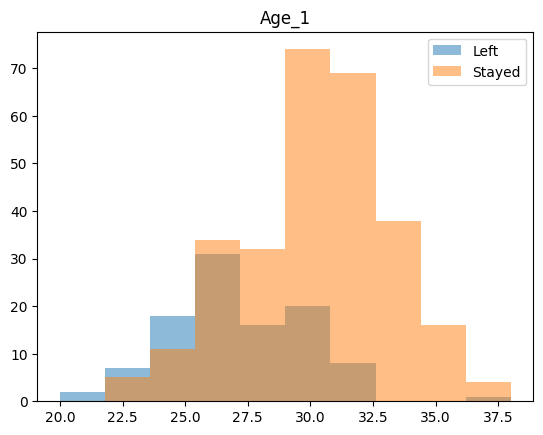

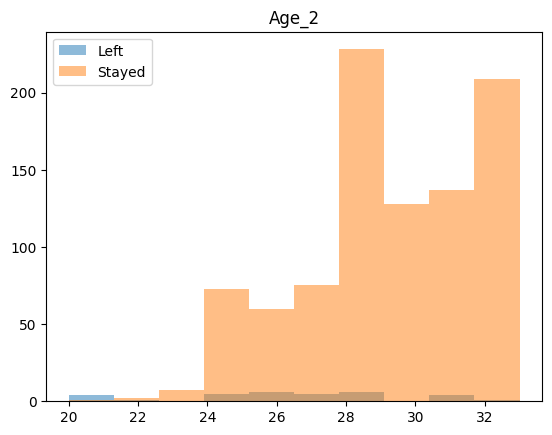

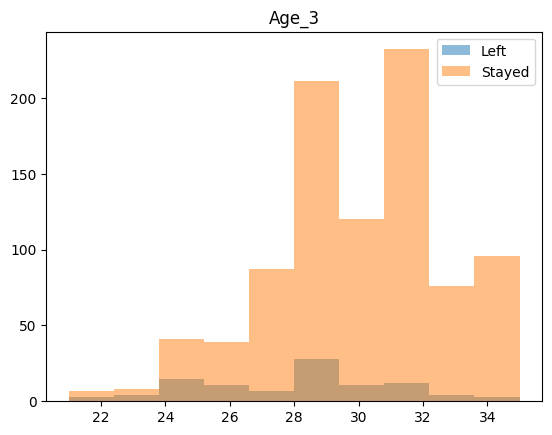

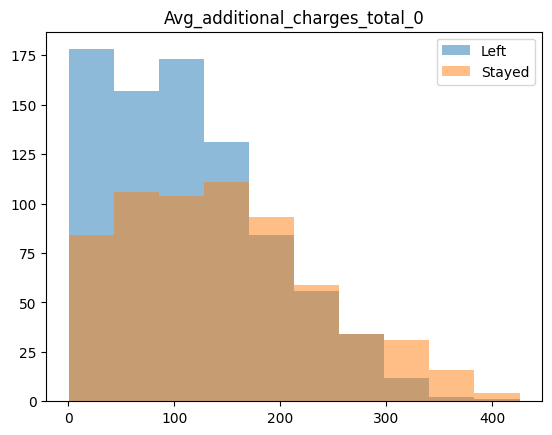

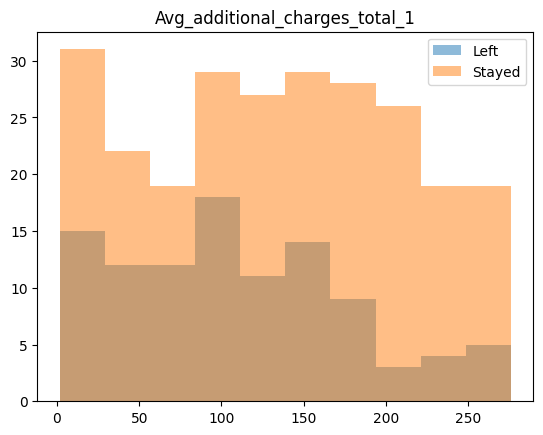

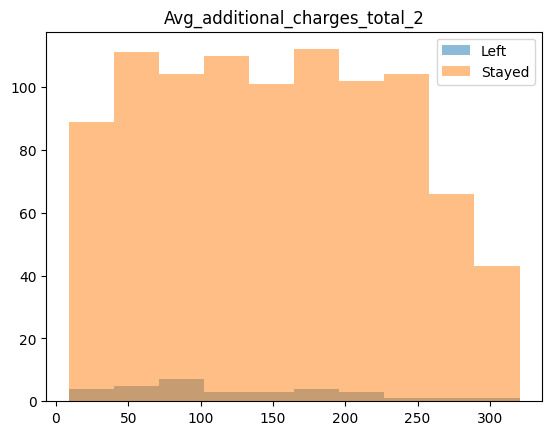

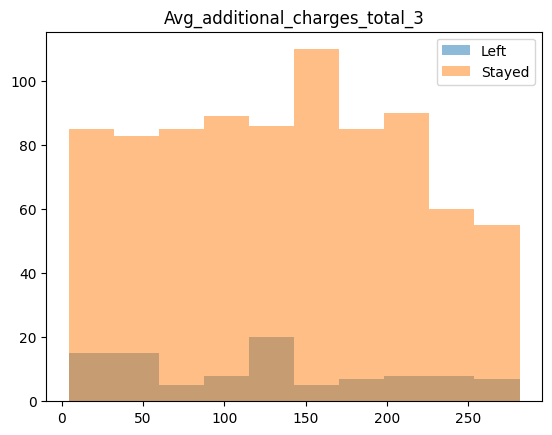

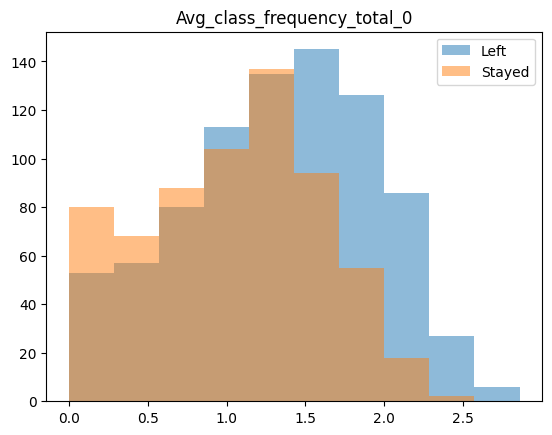

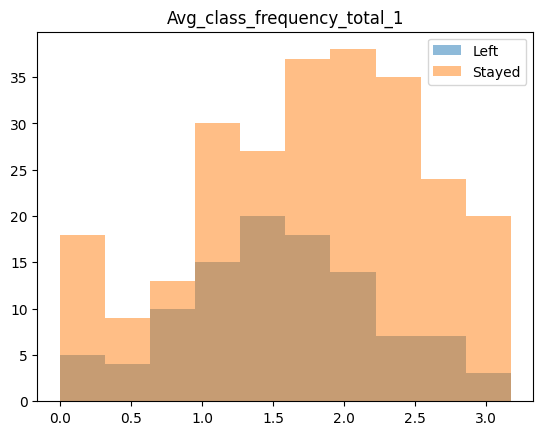

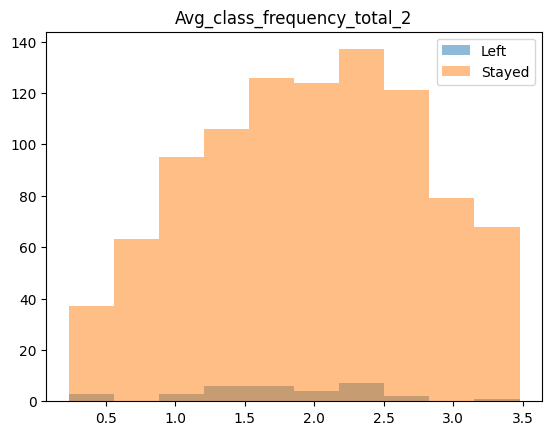

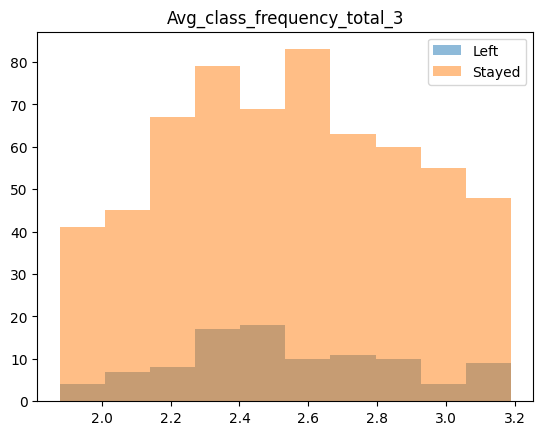

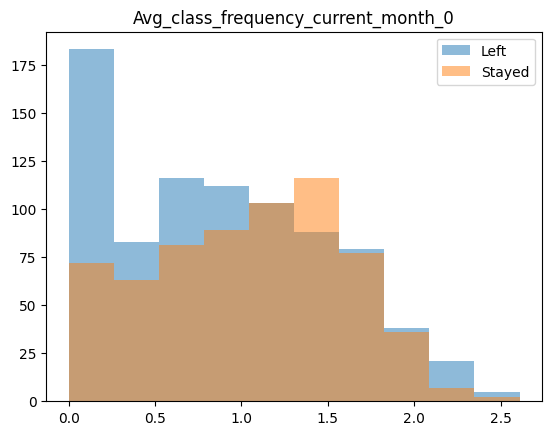

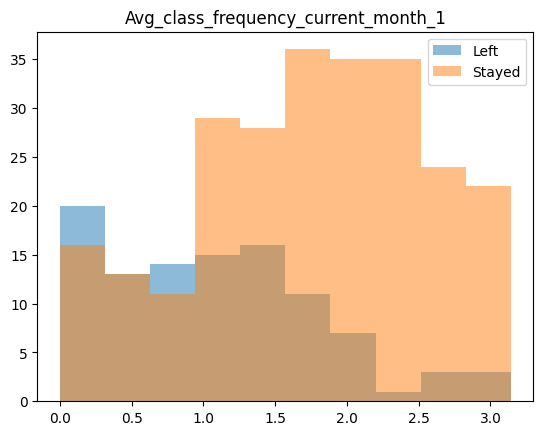

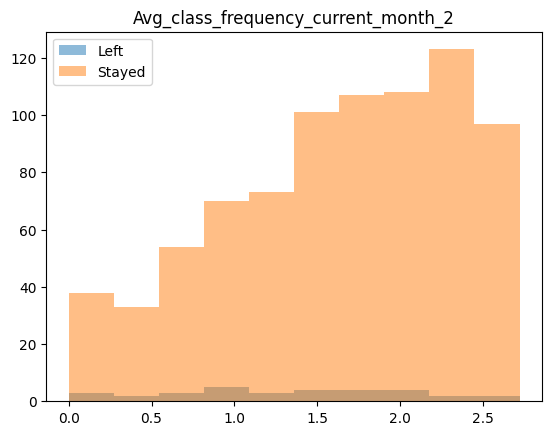

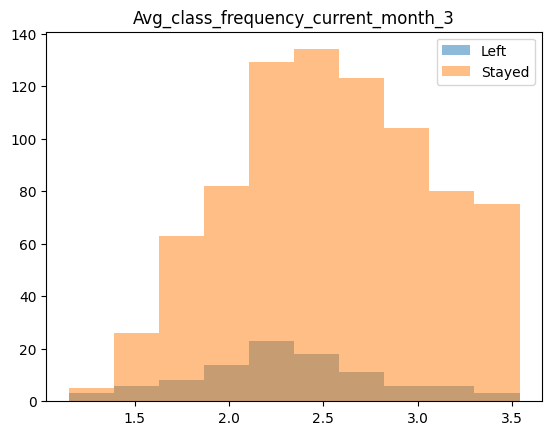

In [33]:
for i in categ2:
    for j  in categ_cat:
        n,bins, patches = plt.hist(left[left['claster'] == j].iloc[:,i], bins = 10, alpha = 0.5, label = 'Left')
        plt.hist(stay[stay['claster'] == j].iloc[:,i], bins = bins,alpha = 0.5, label = 'Stayed')
        plt.legend()
        plt.title(left.columns[i]+'_%i' %j)
        plt.show()

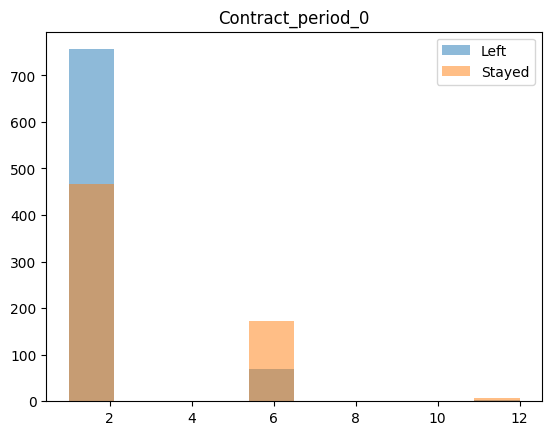

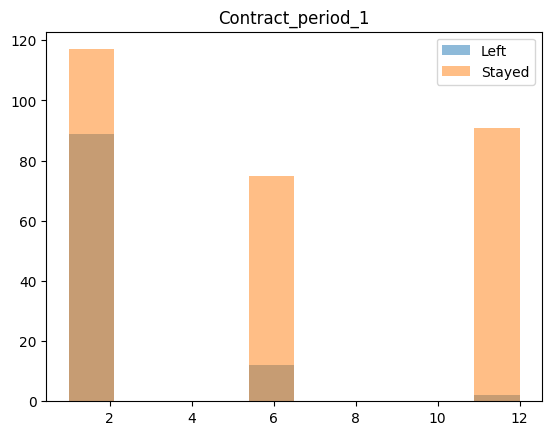

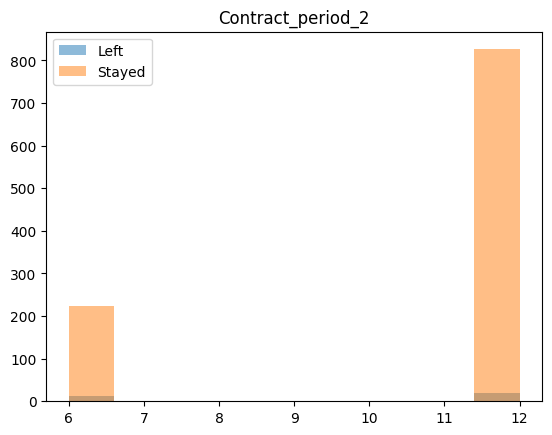

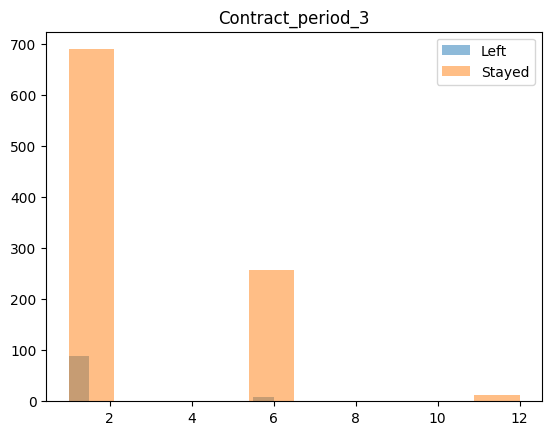

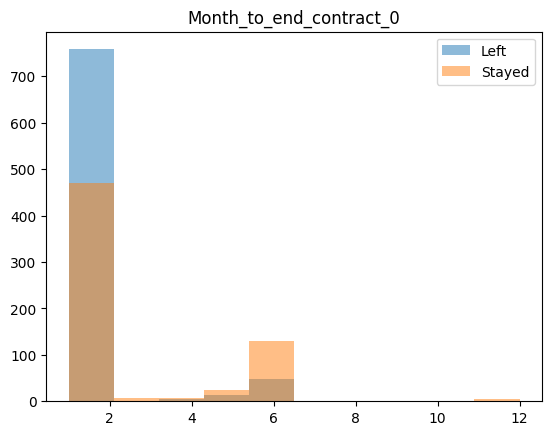

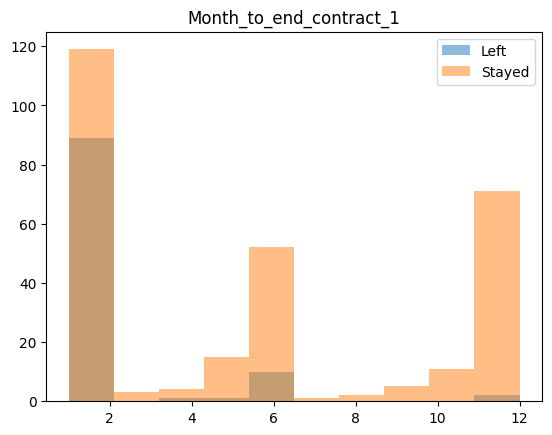

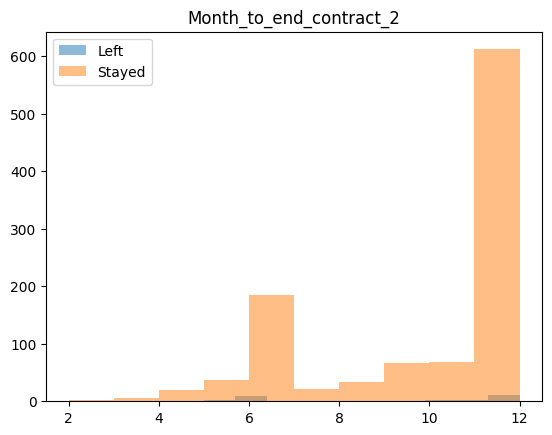

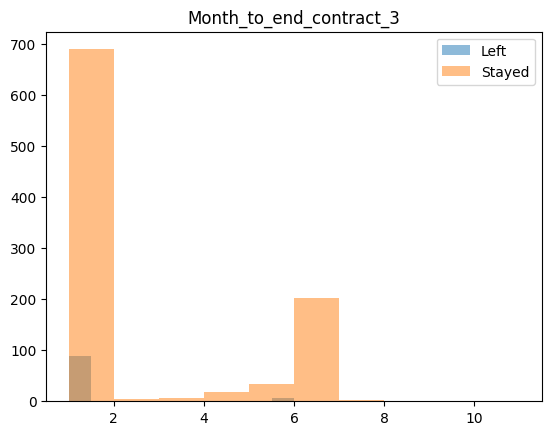

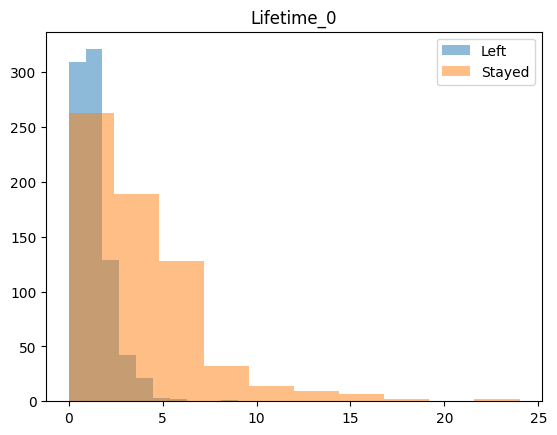

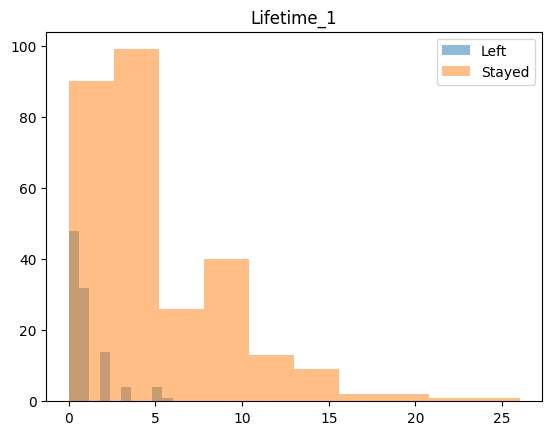

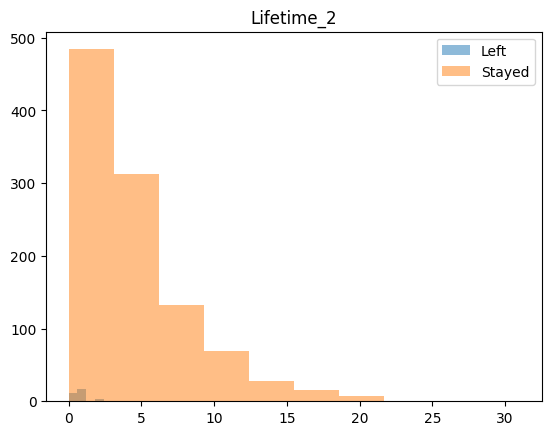

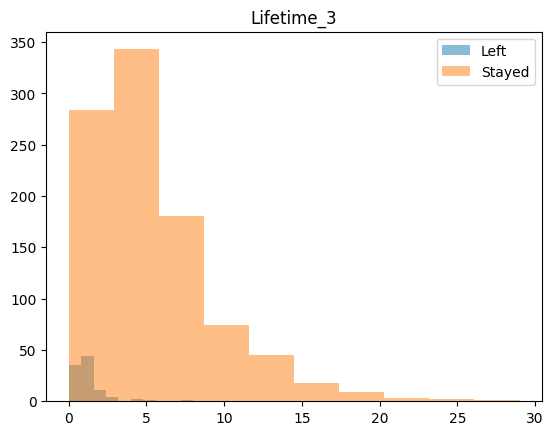

In [34]:
for i in categ3:
    for j  in categ_cat:
        plt.hist(left[left['claster'] == j].iloc[:,i], alpha = 0.5, label = 'Left')
        plt.hist(stay[stay['claster'] == j].iloc[:,i],alpha = 0.5, label = 'Stayed')
        plt.legend()
        plt.title(left.columns[i]+'_%i' %j)
        plt.show()

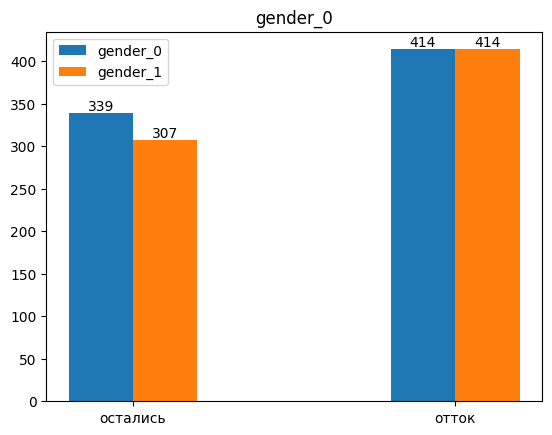

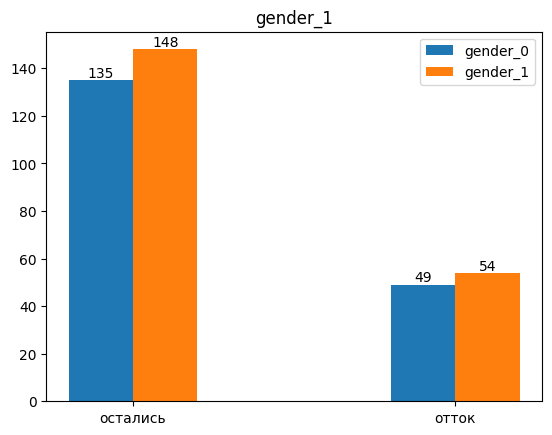

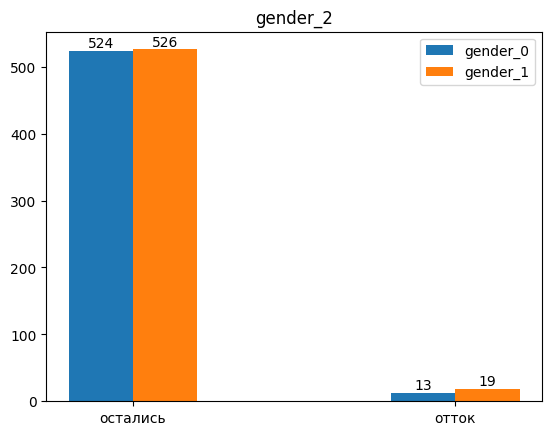

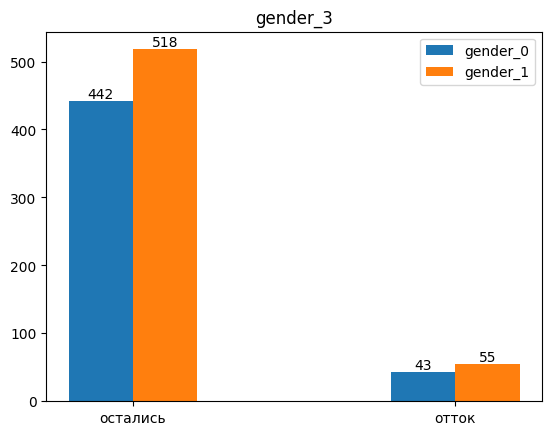

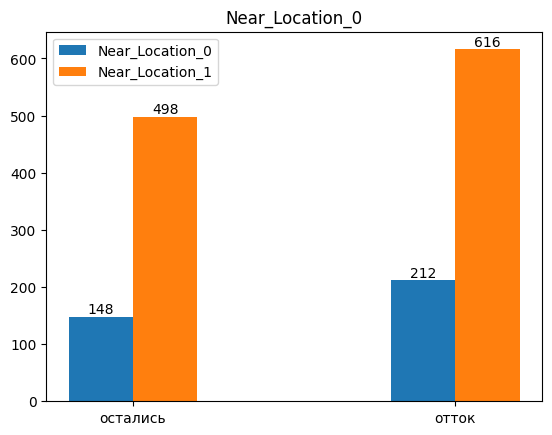

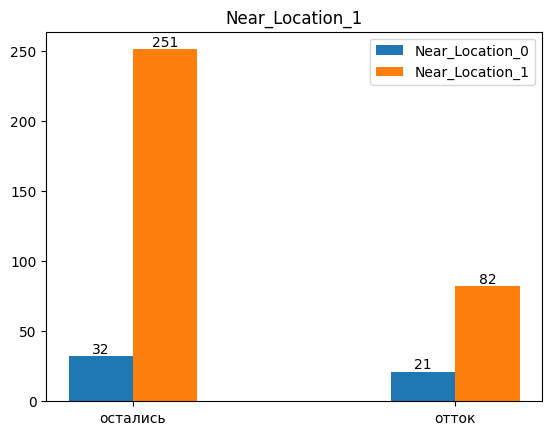

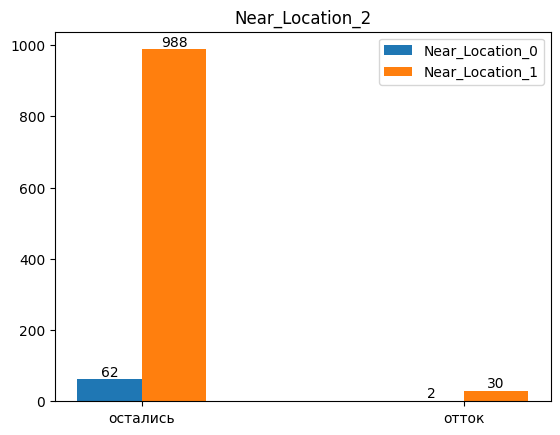

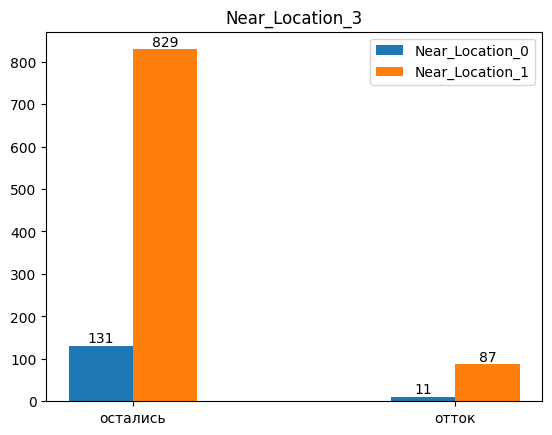

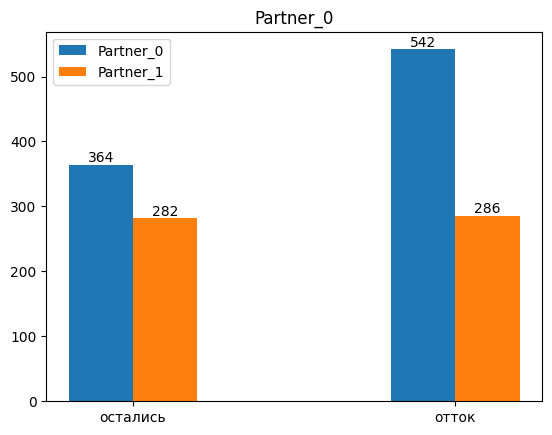

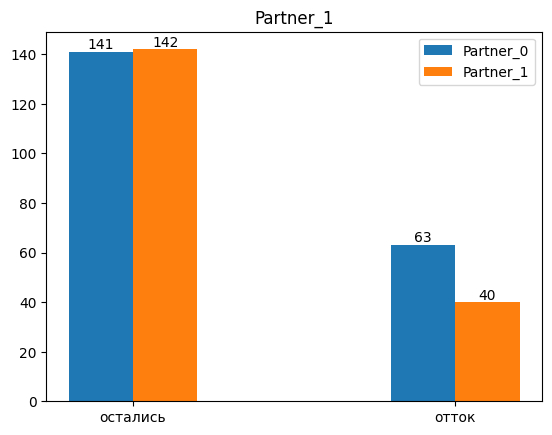

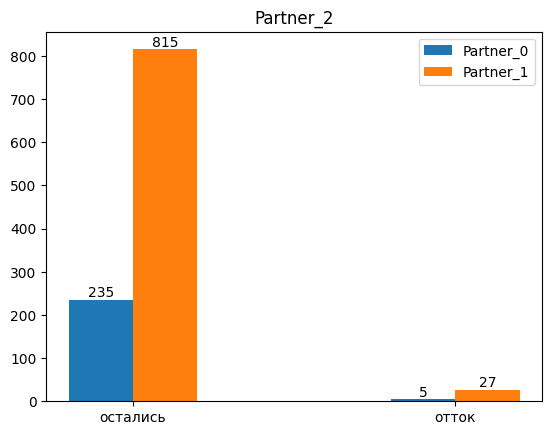

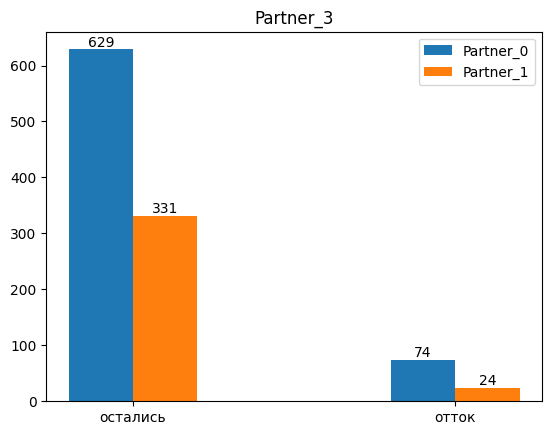

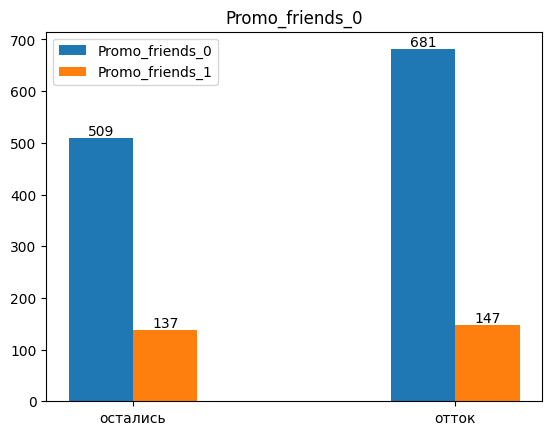

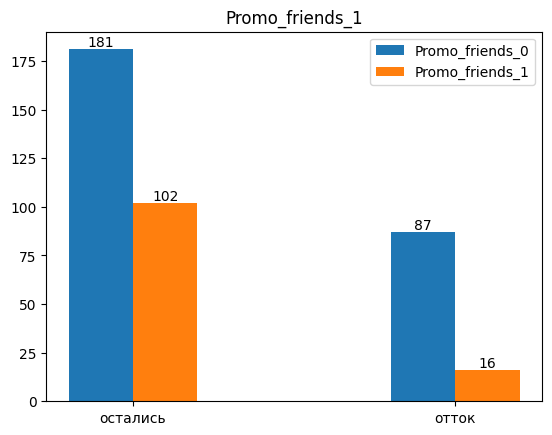

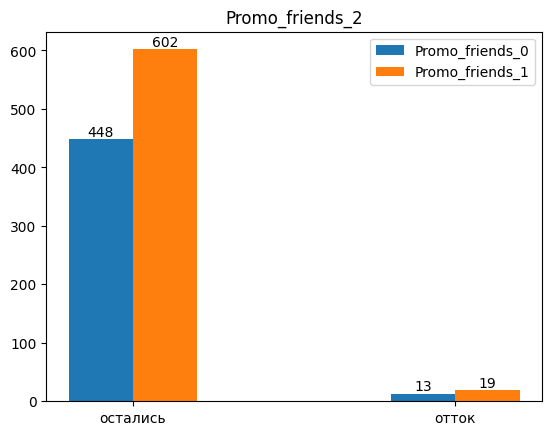

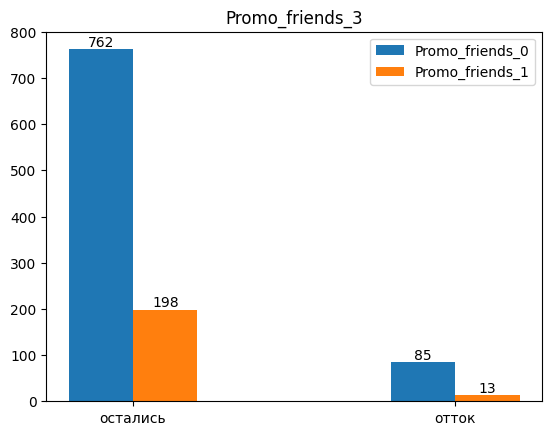

ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements

In [35]:
for i in categ:
    for j in categ_cat:
        pivo = pd.pivot_table(data = fit[fit['claster']==j], index = 'Churn', columns = fit.iloc[:,i], values ='Age', aggfunc = 'count').reset_index()
        pivo.columns=['Churn',fit.columns[i]+'_0', fit.columns[i]+'_1']
        m=plt.bar(x = pivo['Churn']-0.1, height = pivo.iloc[:,1], width = 0.2, label = pivo.columns[1])
        w=plt.bar(x = pivo['Churn']+0.1, height = pivo.iloc[:,2], width = 0.2, label = pivo.columns[2])
        plt.xticks(ticks = [0,1], labels = ['остались','отток'])
        plt.legend()
        plt.bar_label(m)
        plt.bar_label(w)
        plt.title(fit.columns[i]+'_%i' %j)
        plt.show()

<Axes: >

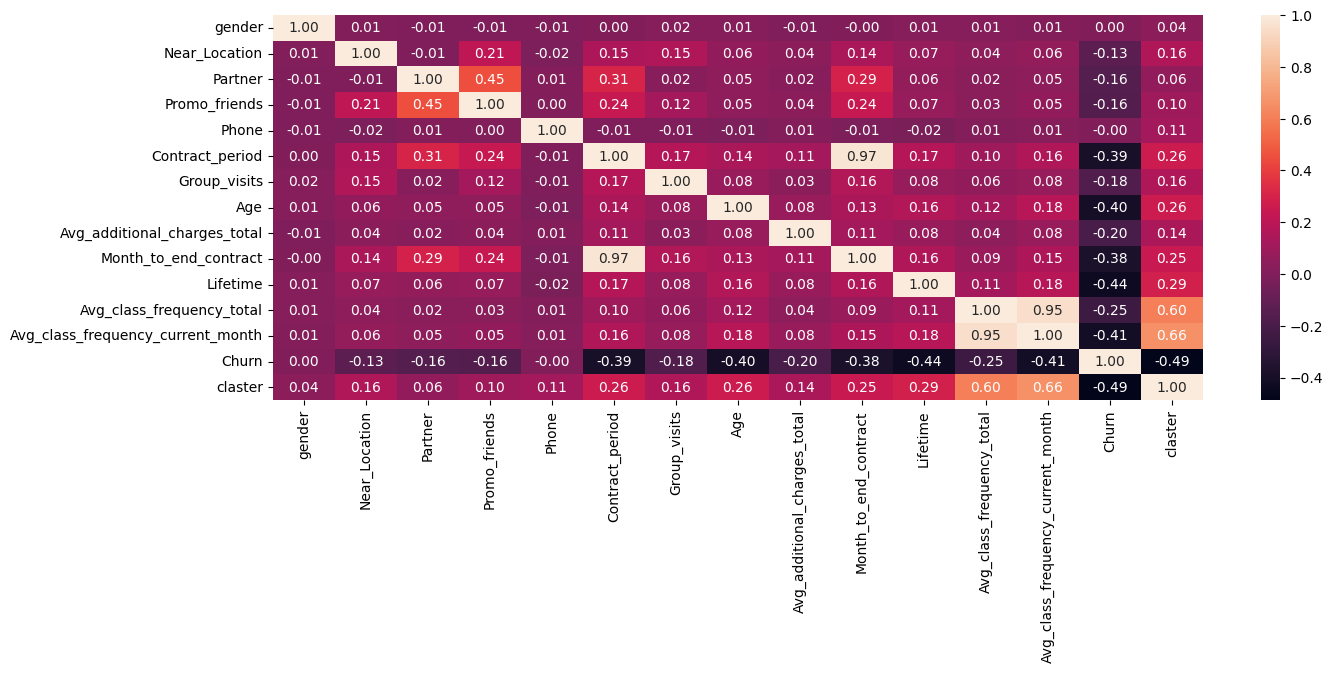

In [36]:
cor = fit.corr()
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(cor, annot = True, fmt = ".2f")

In [37]:
fit.groupby(by = 'claster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
claster,,,,,,,,,,,,,,
0,0.489145,0.755767,0.385346,0.192673,1.0,1.895522,0.291723,28.042062,129.409699,1.802578,2.232022,1.203721,0.949771,0.561737
1,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
2,0.503697,0.940850,0.778189,0.573937,1.0,10.685767,0.533272,29.896488,161.102734,9.756932,4.720887,1.991351,1.983043,0.029575
3,0.541588,0.865784,0.335539,0.199433,1.0,2.386578,0.450851,30.005671,157.889886,2.224008,4.706994,2.714015,2.700512,0.092628


<a name="marketing"></a>
**Рекомендации для маркетинговой стратегии по группам клиентов:**

* Группа 0: фитнес клуб расположен рядом с домом/работой. Короткий абонемент. Высокий отток. Группа с наибольшим потенциалом для удержания клиентов. Требует максимального фокуса. **Предлагаемые маркетинговые действия:** предложение скидок для долгосрочных абонементов. Стимулирование "приведи друга".
* Группа 1: основная характеристика - фитнес клуб не расположен рядом с домом/работой. При этом являются сотрудниками компаний-партнеров. Характерен короткий абонемент.Уровень оттока высокий. **Предлагаемые маркетинговые действия:** отказаться от маркетинговых усилий, таргетированных на эту группу клиентв из-за их удаленного местанохождения. 
* Группа 2: фитнес клуб расположен рядом с домом/работой. Короткий абонемент. Самые активные посетители. Относительно низкий отток. **Предлагаемые маркетинговые действия:** предложение скидок для долгосрочных абонементов. Предложение дополнительной скидки для компаний-партнеров.Стимулирование "приведи друга".
* Группа 3: фитнес клуб расположен рядом с домом/работой. Длинный абонемент. Низкий отток. Самая лояльная группа. **Предлагаемые маркетинговые действия:** необходимо сосредоточить усилия на предложении дополнительных услуг.


**Рекламная стратегия для всех групп:** охват аудитории, которая живет/работает рядом. Рассылки для клиентов со сроком абонемента менее 1 месяца с предложением о продлении. Аналогичные рассылки для ушеших клиентов. Расширение взаимодействия с компаниями-партнерами.